# Kaggle Dataset: Used Cars

### Importing libraries

In [98]:
import pandas as pd
import numpy as np
import scipy.stats as stats 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore') # To supress warnings
 # set the background for the graphs

from scipy.stats import skew
plt.style.use('ggplot')
# set the background for the graphs

from scipy.stats import skew
plt.style.use('ggplot')
#import missingno as msno # to get visualization on missing values

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth',400)
pd.set_option('display.float_format', lambda x: '%.5f' % x) # To supress numerical display in scientific notations

import statsmodels.api as sm

print("Load Libraries- Done")

Load Libraries- Done


### Custom functions

In [2]:
def calculate_price_in_rupee(row):
    
    '''The function calculates the price in rupees based on values in New_Price column 
    reflected as numbers with scientific notation abbreviations: either in Cr or Lakh. 
    It converts these values into normal numbers using the values from Price_Notation column 
    and assigns new numeric values to New_Price column.'''
    
    price_number = row['New_Price']
    price_text = row['Price_Notation']
     
    conversion_factors ={
        'lakh':100000,
        'cr':10000000
    }
    
    return price_number * conversion_factors.get(price_text, 1)

In [3]:
def convert_to_kilometer_per_litr(row):
    
    """The function converts the values in Fuel_Consumption column to kilometer per litr 
    based on the metrics in Consumption_Measure column"""
    
    consumption = row['Fuel_Consumption']
    measure = row['Consumption_Measure']
    
    conversion_factors = {'kmpl': 1,
                          'km/kg': 1.40}  # Invert conversion factor for km/kg
    
    return consumption * conversion_factors.get(measure, 1)

## Initial Data Examination and Exploration

In [4]:
used_cars = pd.read_csv('used_cars_data.csv')

In [91]:
used_cars.sample(7, random_state = 123)

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,...,Price,Horse_Power,Horse_Power_Unit,Engine_Power,Engine_Power_Unit,Price_Notation,Fuel_Consumption,Consumption_Measure,Fuel_Consumption_kmpl,Brand
4289,4289,Hyundai Verna Transform Xxi ABS,Bangalore,2011,60000,Petrol,Manual,First,16.2 kmpl,1599 CC,...,3.95,103.20,bhp,1599.0,CC,NaN,16.20,kmpl,16.20,Hyundai
3718,3718,Volkswagen Polo Diesel Comfortline 1.2L,Delhi,2013,77445,Diesel,Manual,First,22.07 kmpl,1199 CC,...,3.75,73.90,bhp,1199.0,CC,NaN,22.07,kmpl,22.07,Volkswagen
1565,1565,Volkswagen Passat Diesel Highline 2.0 TDI,Chennai,2011,95000,Diesel,Automatic,Second,18.33 kmpl,1968 CC,...,8.50,167.70,bhp,1968.0,CC,NaN,18.33,kmpl,18.33,Volkswagen
3294,3294,Chevrolet Beat LT,Pune,2011,48000,Petrol,Manual,Second,18.6 kmpl,1199 CC,...,1.80,79.40,bhp,1199.0,CC,NaN,18.60,kmpl,18.60,Chevrolet
2823,2823,Volkswagen Jetta 2013-2015 2.0L TDI Highline AT,Chennai,2015,480000,Diesel,Automatic,First,16.96 kmpl,1968 CC,...,13.00,138.03,bhp,1968.0,CC,NaN,16.96,kmpl,16.96,Volkswagen
192,192,Ford Figo Diesel ZXI,Chennai,2010,120000,Diesel,Manual,First,20.0 kmpl,1399 CC,...,2.60,68.00,bhp,1399.0,CC,NaN,20.00,kmpl,20.00,Ford
4093,4093,Maruti Ciaz ZDi,Delhi,2015,46166,Diesel,Manual,Second,26.21 kmpl,1248 CC,...,5.50,88.50,bhp,1248.0,CC,NaN,26.21,kmpl,26.21,Maruti


In [6]:
used_cars.shape

(7253, 14)

In [7]:
used_cars.describe()

,S.No.,Year,Kilometers_Driven,Seats,Price
count,7253.000000,7253.000000,7.253000e+03,7200.000000,6019.000000
mean,3626.000000,2013.365366,5.869906e+04,5.279722,9.479468
std,2093.905084,3.254421,8.442772e+04,0.811660,11.187917
min,0.000000,1996.000000,1.710000e+02,0.000000,0.440000
25%,1813.000000,2011.000000,3.400000e+04,5.000000,3.500000
50%,3626.000000,2014.000000,5.341600e+04,5.000000,5.640000
75%,5439.000000,2016.000000,7.300000e+04,5.000000,9.950000
max,7252.000000,2019.000000,6.500000e+06,10.000000,160.000000


In [8]:
used_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No.              7253 non-null   int64  
 1   Name               7253 non-null   object 
 2   Location           7253 non-null   object 
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7207 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 793.4+ KB


In [9]:
used_cars.columns.tolist()

['S.No.',
 'Name',
 'Location',
 'Year',
 'Kilometers_Driven',
 'Fuel_Type',
 'Transmission',
 'Owner_Type',
 'Mileage',
 'Engine',
 'Power',
 'Seats',
 'New_Price',
 'Price']

In [10]:
used_cars.isna().sum()

S.No.                   0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                  46
Seats                  53
New_Price            6247
Price                1234
dtype: int64

# Data Preprocessing for Further Analysis

### In 'Power', 'Engine', 'Mileage' & 'New_Price' columns splitting numbers and respective metrics

In [11]:
used_cars[['Horse_Power', 'Horse_Power_Unit']] = used_cars['Power'].str.split(' ', expand=True)

In [12]:
used_cars[['Horse_Power', 'Horse_Power_Unit']].head(2)

,Horse_Power,Horse_Power_Unit
0,58.16,bhp
1,126.2,bhp


In [13]:
# There are values equal to string 'null' in 'Hourse_Power' that needs to be treated 
used_cars.loc[used_cars['Horse_Power'] == 'null', 'Horse_Power'] = pd.NA

In [14]:
# Converting 'Hours_Power' column to numeric type
used_cars['Horse_Power'] = pd.to_numeric(used_cars['Horse_Power'])

#### splitting values in Engine column

In [15]:
used_cars[['Engine_Power', 'Engine_Power_Unit']] = used_cars['Engine'].str.split(' ', expand=True)

In [16]:
used_cars[['Engine_Power', 'Engine_Power_Unit']].head(2)

,Engine_Power,Engine_Power_Unit
0,998,CC
1,1582,CC


#### splitting values in New_Price column

In [17]:
used_cars[['New_Price', 'Price_Notation']] = used_cars['New_Price'].str.split(' ', expand = True)

In [18]:
used_cars['New_Price'] = used_cars['New_Price'].str.strip()

In [19]:
used_cars['New_Price'] = pd.to_numeric(used_cars['New_Price'])

In [20]:
# Apply the function to convert everything to rupee in New_Price
used_cars['New_Price'] = used_cars.apply(calculate_price_in_rupee, axis=1)

In [21]:
used_cars[['New_Price', 'Price_Notation']].sample(2,random_state = 1)

,New_Price,Price_Notation
2397,9.47,Lakh
3777,5.44,Lakh


#### splitting values in Mileage

In [22]:
used_cars[['Fuel_Consumption', 'Consumption_Measure']] = used_cars['Mileage'].str.split(' ', expand = True)

In [23]:
used_cars['Fuel_Consumption'] = pd.to_numeric(used_cars['Fuel_Consumption'])

In [24]:
used_cars[['Fuel_Consumption', 'Consumption_Measure']].head(2)

,Fuel_Consumption,Consumption_Measure
0,26.60,km/kg
1,19.67,kmpl


<span style ='color:red'>[Note] There are two different measures in Mileage_Measure column that must be converted to identical measure</span>

In [25]:
used_cars['Consumption_Measure'].value_counts()

Consumption_Measure
kmpl     7177
km/kg      74
Name: count, dtype: int64

### Adding new column: Fuel_Consumption_kmpl, where all measures are converted to kmpl

In [26]:
used_cars['Fuel_Consumption_kmpl'] = used_cars.apply(convert_to_kilometer_per_litr, axis=1)

In [27]:
used_cars[['Fuel_Consumption_kmpl','Mileage']][used_cars['Consumption_Measure']== 'km/kg'].sample(5)

,Fuel_Consumption_kmpl,Mileage
839,37.562,26.83 km/kg
3869,46.816,33.44 km/kg
4098,29.960,21.4 km/kg
2059,46.956,33.54 km/kg
6019,45.164,32.26 km/kg


<span style ='color:red'> Since ISUZU and Isuzu are same, we must correct that </span>

In [28]:
# illustrating all unique brands
brand_list = list(used_cars['Name'].str.split().str[0].unique())
brand_list

['Maruti',
 'Hyundai',
 'Honda',
 'Audi',
 'Nissan',
 'Toyota',
 'Volkswagen',
 'Tata',
 'Land',
 'Mitsubishi',
 'Renault',
 'Mercedes-Benz',
 'BMW',
 'Mahindra',
 'Ford',
 'Porsche',
 'Datsun',
 'Jaguar',
 'Volvo',
 'Chevrolet',
 'Skoda',
 'Mini',
 'Fiat',
 'Jeep',
 'Smart',
 'Ambassador',
 'Isuzu',
 'ISUZU',
 'Force',
 'Bentley',
 'Lamborghini',
 'Hindustan',
 'OpelCorsa']

In [29]:
# replacing ISUZU with Isuzu
used_cars['Brand'] = used_cars['Name'].str.split().str[0].str.replace('ISUZU', 'Isuzu')

In [30]:
# replacing Land with Land Rover
used_cars['Brand'] = used_cars['Brand'].str.replace('Land', 'Land Rover')

# Changing Data Types

In [31]:
# converting Engine_Power to numeric
used_cars['Engine_Power'] = pd.to_numeric(used_cars['Engine_Power'])

# Data Visualization

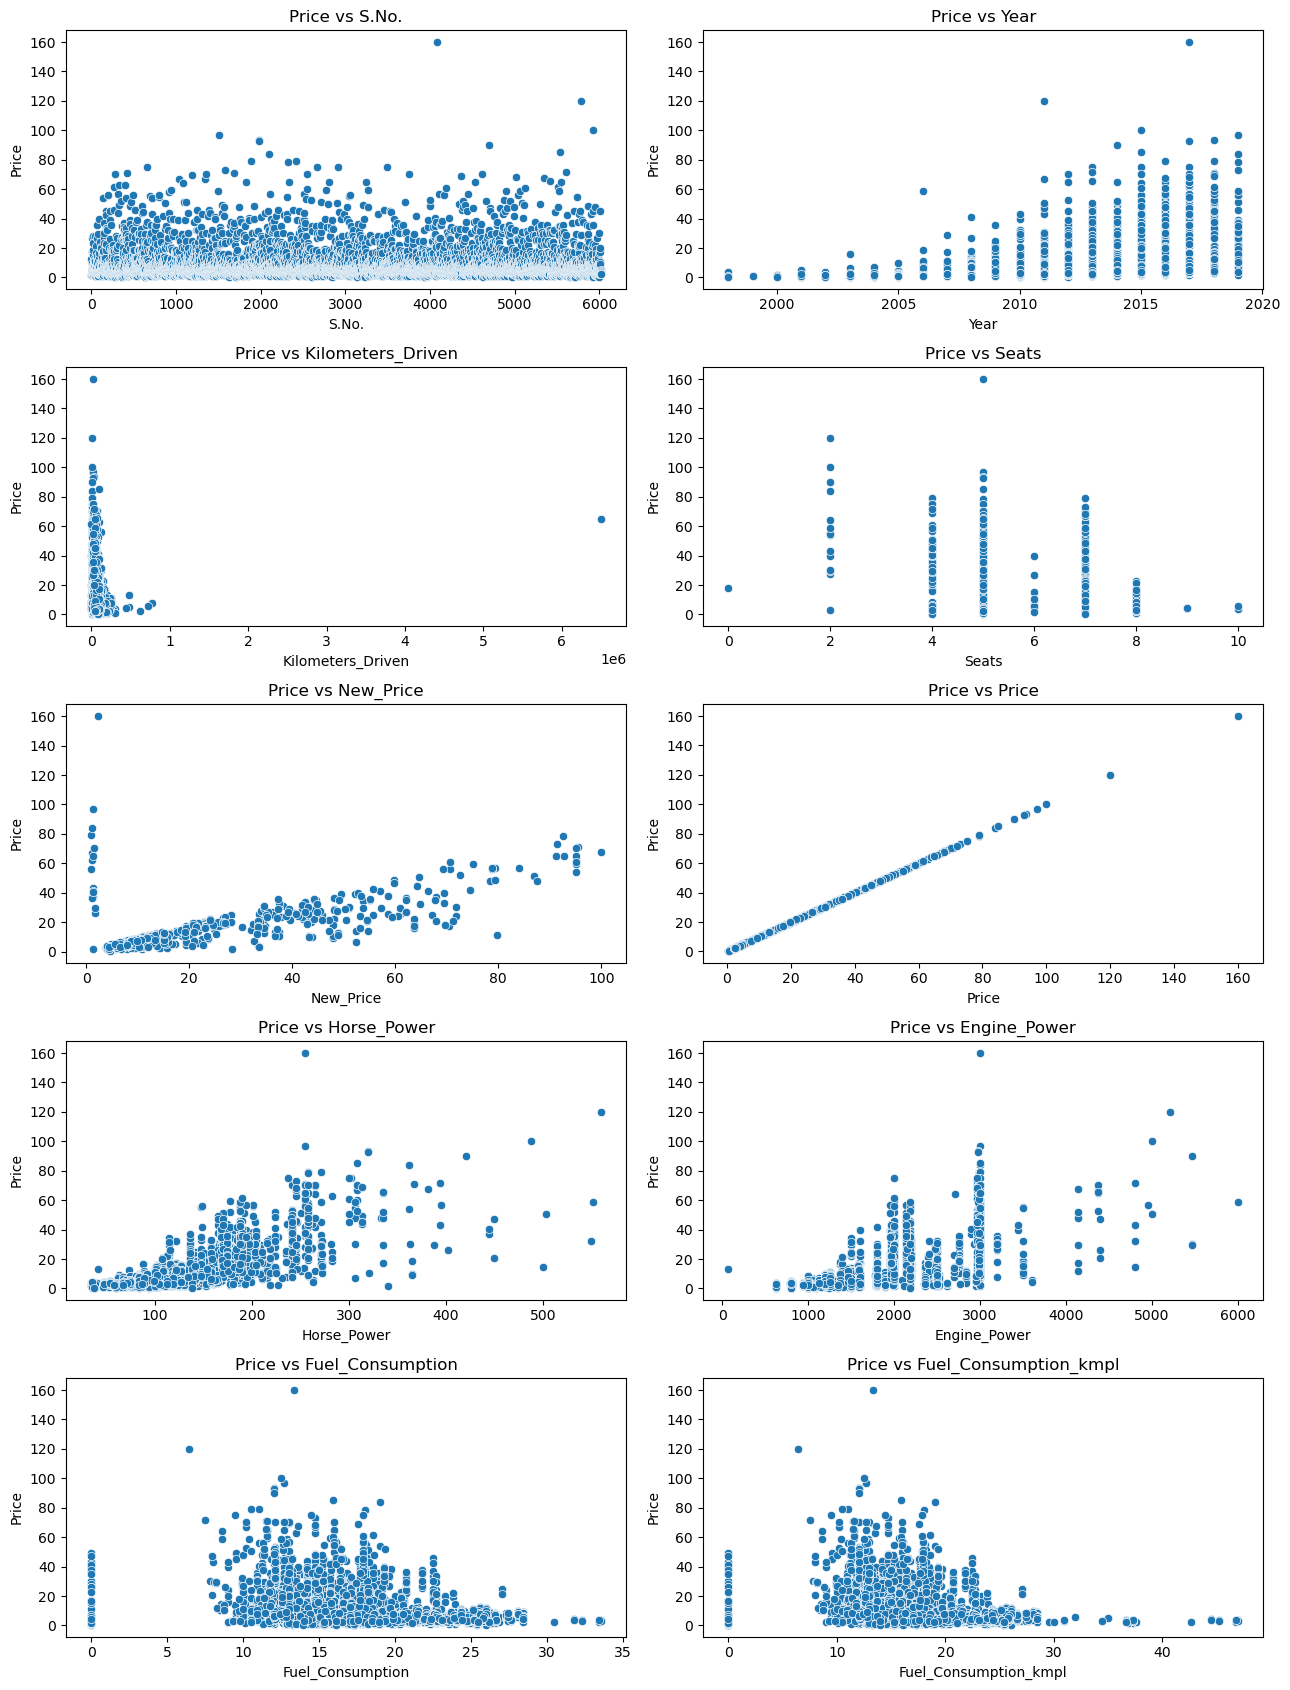

In [93]:
numeric_columns= numeric_columns = used_cars.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(13,17))

for i, variable in enumerate(numeric_columns):
                     plt.subplot(5,2,i+1)
                     sns.scatterplot(x=used_cars[variable],y=used_cars['Price']).set(title='Price vs '+ variable)
                     #plt.xticks(rotation=90)
                     plt.tight_layout()

### Distribution of Data

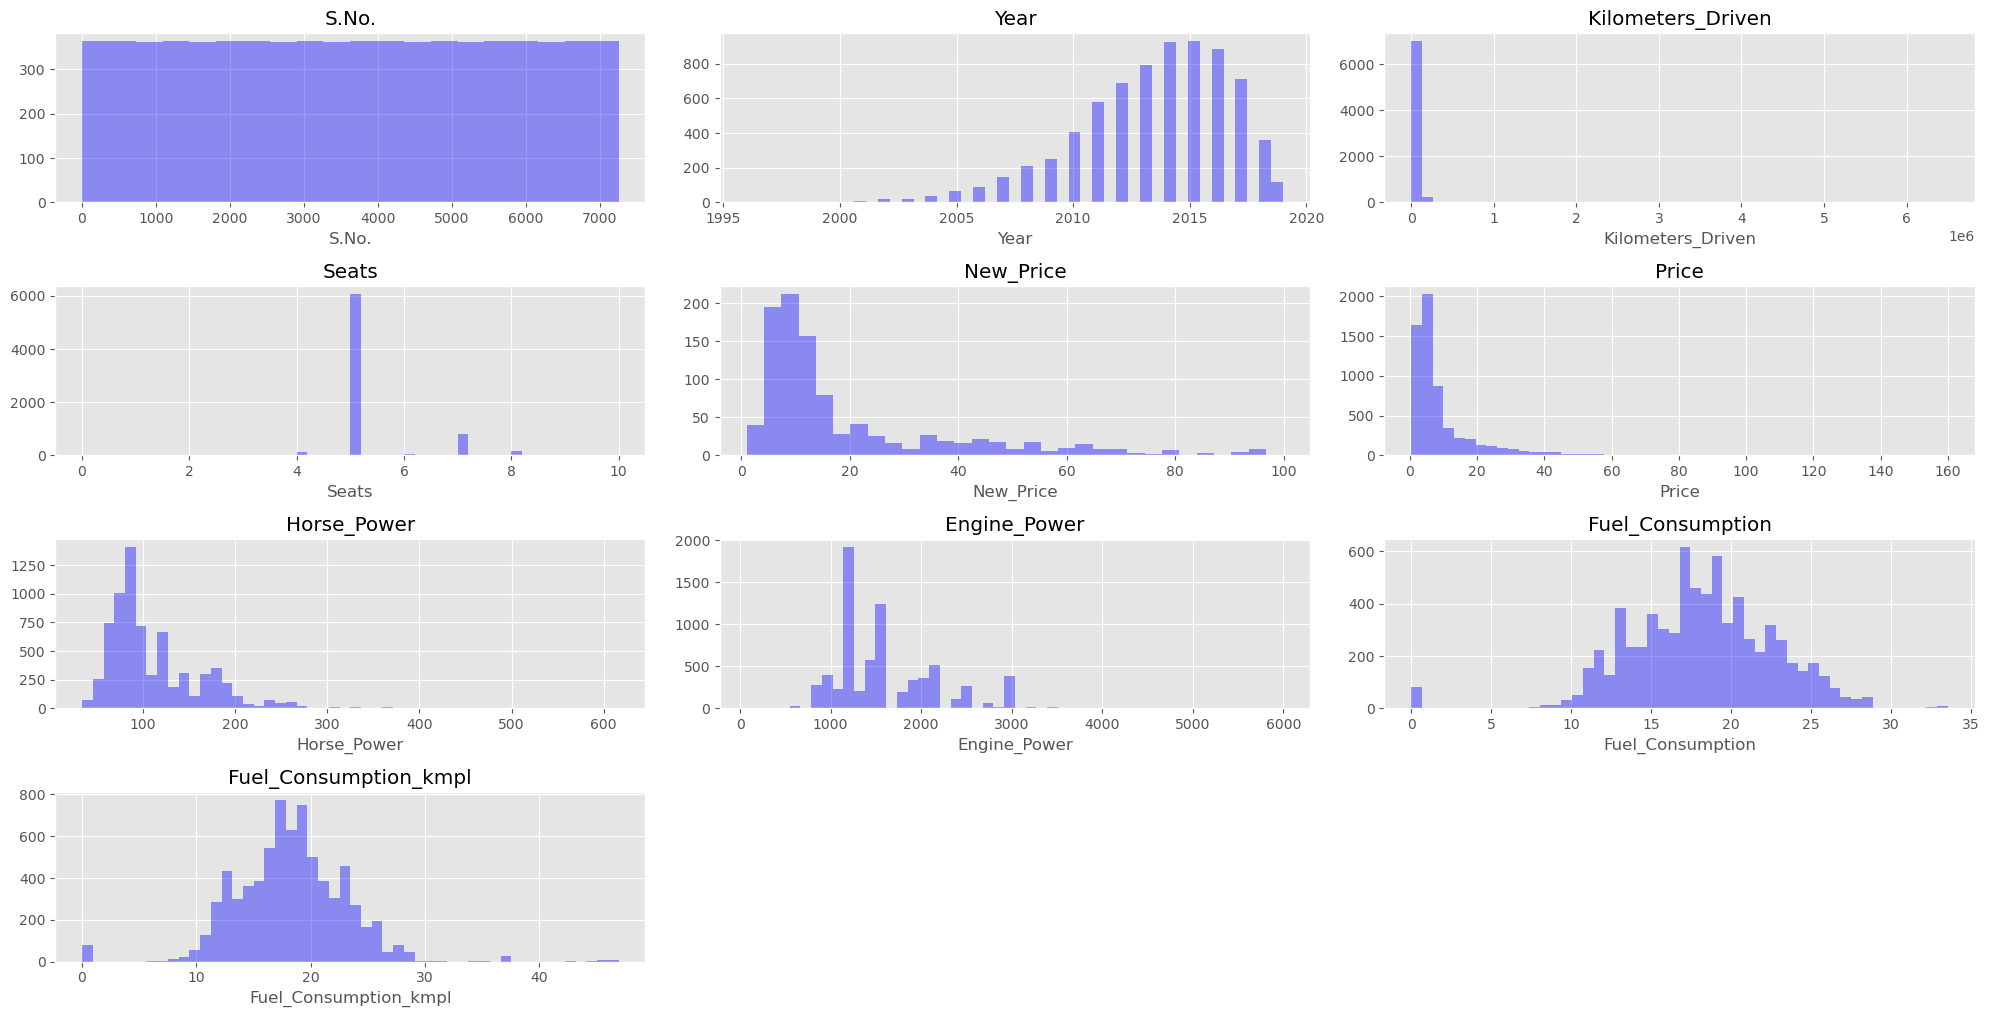

In [99]:
plt.style.use('ggplot')
#select all quantitative columns for checking the spread
numeric_columns = used_cars.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(20,25))

for i, variable in enumerate(numeric_columns):
                     plt.subplot(10,3,i+1)
                       
                     sns.distplot(used_cars[variable],kde=False,color='blue')
                     plt.tight_layout()
                     plt.title(variable)

# **Applying ML Algorithms:**
1. Regression Model

<span style = "color:red;font-size:16px"> In the first model, the part of data with not missing values in New_Price column is employed by spliting it into test and train datasets</span>

### Data preprocessing 

In [36]:
data = used_cars.dropna(subset=['New_Price'])

In [37]:
# Drop rows with missing values in specified columns
data = data.dropna(subset=['Fuel_Consumption', 'Consumption_Measure', 'Fuel_Consumption_kmpl'])

In [38]:
# Fill missing values in 'Price' column with median
median_price = data['Price'].median()
data['Price'].fillna(median_price, inplace=True)

In [39]:
data.isna().sum()

S.No.                    0
Name                     0
Location                 0
Year                     0
Kilometers_Driven        0
Fuel_Type                0
Transmission             0
Owner_Type               0
Mileage                  0
Engine                   0
Power                    0
Seats                    0
New_Price                0
Price                    0
Horse_Power              0
Horse_Power_Unit         0
Engine_Power             0
Engine_Power_Unit        0
Price_Notation           0
Fuel_Consumption         0
Consumption_Measure      0
Fuel_Consumption_kmpl    0
Brand                    0
dtype: int64

In [40]:
# Drop unnecessary columns
columns_to_remove = ['S.No.', 'Name', 'Location', 'Mileage', 'Engine', 'Power', 'Horse_Power_Unit',
                     'Engine_Power_Unit', 'Price_Notation', 'Fuel_Consumption', 'Consumption_Measure']

data_encoded = data.drop(columns=columns_to_remove)

In [41]:
# Encode categorical variables using one-hot encoding
categorical_features = ['Fuel_Type', 'Transmission', 'Owner_Type','Brand']  # Replace with actual categorical feature names
data_encoded = pd.get_dummies(data_encoded, columns=categorical_features, drop_first=True)

In [42]:
# Split features (X) and target variable (y)
X = data_encoded.drop(columns=['New_Price'])  
y = data_encoded['New_Price']

In [43]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Initialize and train the linear regression model
LR = LinearRegression().fit(X_train, y_train)

In [45]:
predictions_first_model = LR.predict(X_test)

In [46]:
X_test['Predicted_NewPrice'] = predictions_first_model

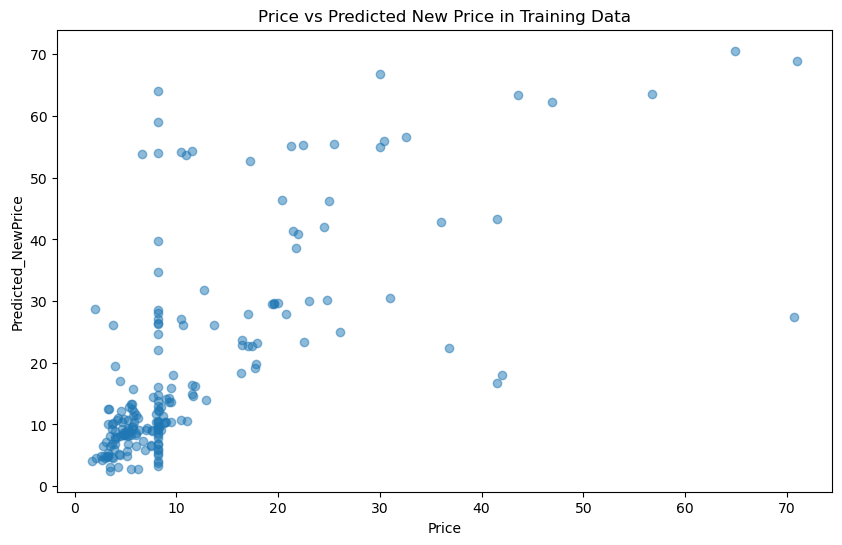

In [47]:
# Step 1: Visualize 'Price' vs 'New_Price' in training data
plt.figure(figsize=(10, 6))
plt.scatter(X_test['Price'], X_test['Predicted_NewPrice'], alpha=0.5)
plt.xlabel('Price')
plt.ylabel('Predicted_NewPrice')
plt.title('Price vs Predicted New Price in Training Data')
plt.show()

In [48]:
X_test.describe().transpose()[['min','max','mean','count']]

,min,max,mean,count
Year,2005.000000,2019.000000,2015.746269,201.0
Kilometers_Driven,1000.000000,169006.000000,39918.686567,201.0
Seats,2.000000,8.000000,5.293532,201.0
Price,1.750000,70.990000,11.522537,201.0
Horse_Power,47.300000,367.000000,117.877015,201.0
Engine_Power,796.000000,2996.000000,1575.955224,201.0
Fuel_Consumption_kmpl,10.800000,46.956000,19.868438,201.0
Predicted_NewPrice,2.508165,70.577121,18.695179,201.0


<span style = "color:red;font-size:16px"> In the second model, the part of data with not missing values in
New_Price column is employed entirely as train dataset, while the part of data with missing values employed as test. However, we will not be able to test the model accuracy with usual metrics while we do not have actual values (y) from test data(because they are missing)</span>

##### Spliting data into test and training datasets

In [49]:
# creating test data
test_data = used_cars[used_cars['New_Price'].isna()]

In [50]:
# creating training data
training_data = used_cars[used_cars['New_Price'].notna()]

In [51]:
# removing missing values in Price column of training data
training_data = training_data.dropna(subset = ['Price'])

<span style = "color:red;font-size:16px">**Keeping Only Unique Values**</span>

##### Because I will do one-heat encoding: Meaning that all unique variables in selected categorical columns will be separate features, If test data and training data dont contain the length of features, the model will give an error. Therefore, I want to be sure that both datasets contain only the identical values.

### Treating data in Brand Column

In [52]:
# Find the intersection of unique values in column Brand between training_data and test_data
common_values = set(test_data['Brand']).intersection(training_data['Brand'])

In [53]:
# Filter test and training data to keep only the rows with common values in column Brand
test_data = test_data[test_data['Brand'].isin(common_values)]

In [54]:
training_data = training_data[training_data['Brand'].isin(common_values)]

### Treating data in Owner_Type column

In [55]:
# Find the intersection of unique values in column Owner_Type between training_data and test_data
common_values = set(test_data['Owner_Type']).intersection(training_data['Owner_Type'])

In [56]:
# Filter test and training data to keep only the rows with common values in column Brand
test_data = test_data[test_data['Owner_Type'].isin(common_values)]

In [57]:
training_data = training_data[training_data['Owner_Type'].isin(common_values)]

In [58]:
test_data.shape, training_data.shape

((6075, 23), (809, 23))

## Preprossesing Test Data

In [59]:
test_data.isna().sum()

S.No.                       0
Name                        0
Location                    0
Year                        0
Kilometers_Driven           0
Fuel_Type                   0
Transmission                0
Owner_Type                  0
Mileage                     1
Engine                     45
Power                      45
Seats                      52
New_Price                6075
Price                    1017
Horse_Power               169
Horse_Power_Unit           45
Engine_Power               45
Engine_Power_Unit          45
Price_Notation           6075
Fuel_Consumption            1
Consumption_Measure         1
Fuel_Consumption_kmpl       1
Brand                       0
dtype: int64

In [60]:
# Remove rows where columns Horse_Power and Engine_Power are all missing
test_data = test_data.dropna(subset=['Horse_Power', 'Engine_Power'], how='all')

In [61]:
# Removing all rows where Price and Fuel consumption are missing
test_data = test_data.dropna(subset = ['Price','Fuel_Consumption_kmpl'])

<span style = "color:red">[Note] I am replacing missing values in Horse_Power column using simple using a simple imputation technique (ratio technique). The average ratio of Horse Power to Engine in the dataset </span>

In [62]:
# Calculate the average ratio of 'Horse Power' to 'Engine Power'
average_ratio = test_data['Horse_Power'].div(test_data['Engine_Power']).mean()

In [63]:
# Replace missing 'Horse Power' values based on 'Engine Power'
missing_hp_mask = test_data['Horse_Power'].isna() & test_data['Engine_Power'].notna()
test_data.loc[missing_hp_mask, 'Horse_Power'] = test_data.loc[missing_hp_mask, 'Engine_Power'] * average_ratio

<span style = "color:red; font-size:16px">Replacing Missing Seats with Average of Data</span>

In [64]:
# Calculate the average number of seats in the training_data DataFrame
average_seats = test_data['Seats'].mean()

In [65]:
# Replace missing values in the 'Seats' column of the test_data DataFrame with the average seats
test_data['Seats'].fillna(average_seats, inplace=True)

### Treating data in Fuel_Type Column

In [66]:
common_values = set(test_data['Fuel_Type']).intersection(training_data['Fuel_Type'])

In [67]:
test_data = test_data[test_data['Fuel_Type'].isin(common_values)]

In [68]:
training_data = training_data[training_data['Fuel_Type'].isin(common_values)]

In [69]:
training_data.shape, test_data.shape

((808, 23), (5012, 23))

### Feature Engineering 

In [70]:
# features to be deleted
columns_to_remove = ['S.No.','Name','Location','Mileage',
                     'Engine','Power','Horse_Power_Unit',
                     'Engine_Power_Unit','Price_Notation',
                     'Fuel_Consumption','Consumption_Measure']

In [71]:
test_data = test_data.drop(columns = columns_to_remove)

In [72]:
training_data = training_data.drop(columns = columns_to_remove)

In [73]:
# Extracting features and target variable for training set
x_train = training_data.drop(columns = 'New_Price')

In [74]:
y_train = training_data['New_Price']

In [75]:
# Extracting features for test set (excluding the target variable)
x_test = test_data.drop(columns = 'New_Price')

In [76]:
y_test = test_data[test_data['New_Price'].isna()]['New_Price']

#### Encoding categorical variables using one-hot encoding

In [77]:
training_data_encoded = pd.get_dummies(training_data, columns=['Fuel_Type', 'Transmission', 'Owner_Type','Brand'])

In [78]:
test_data_encoded = pd.get_dummies(test_data, columns=['Fuel_Type', 'Transmission', 'Owner_Type','Brand'])

#### delete features from test data which are not in training data

In [79]:
# Update X_train and X_test with the encoded features
x_train_encoded = training_data_encoded.drop(columns=['New_Price'])

In [80]:
x_test_encoded = test_data_encoded.drop(columns=['New_Price'])

#### Training the Model

In [81]:
# Creating the Linear Model
LR = LinearRegression()

In [82]:
# Fitting the training data into the LR model
LR.fit(x_train_encoded,y_train)

LinearRegression()

In [83]:
# Prediction
predictions_second_model = LR.predict(x_test_encoded)

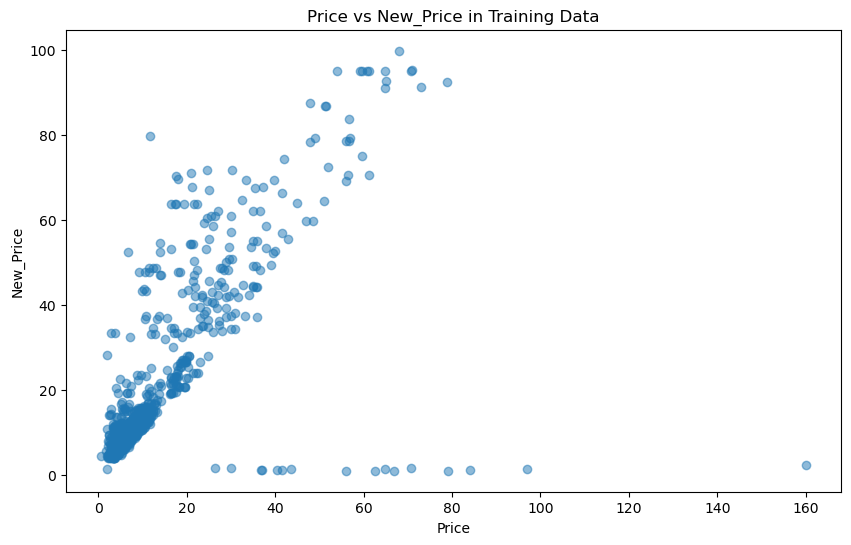

In [84]:
import matplotlib.pyplot as plt

# Step 1: Visualize 'Price' vs 'New_Price' in training data
plt.figure(figsize=(10, 6))
plt.scatter(training_data['Price'], training_data['New_Price'], alpha=0.5)
plt.xlabel('Price')
plt.ylabel('New_Price')
plt.title('Price vs New_Price in Training Data')
plt.show()

In [85]:
# Step 2: Combine predictions into testing data
test_data['Predicted_New_Price'] = predictions_second_model

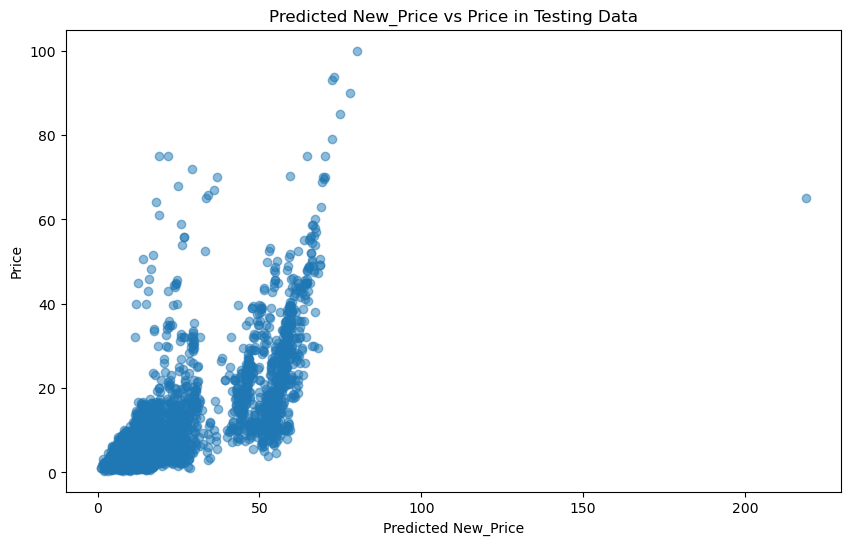

In [86]:
# Step 3: Visualize predicted values vs 'New_Price' in testing data
plt.figure(figsize=(10, 6))
plt.scatter(test_data['Predicted_New_Price'], test_data['Price'], alpha=0.5)
plt.xlabel('Predicted New_Price')
plt.ylabel('Price')
plt.title('Predicted New_Price vs Price in Testing Data')
plt.show()

In [87]:
test_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,5012.0,2013.038707,3.185432,1998.000000,2011.000000,2014.000000,2015.000000,2.019000e+03
Kilometers_Driven,5012.0,61450.421189,98742.457376,171.000000,36889.250000,55674.500000,75000.000000,6.500000e+06
Seats,5012.0,5.274270,0.802166,0.000000,5.000000,5.000000,5.000000,1.000000e+01
New_Price,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,5012.0,8.963815,10.306285,0.440000,3.450000,5.500000,9.312500,1.000000e+02
Horse_Power,5012.0,112.218748,52.847268,34.200000,74.697500,93.700000,138.030000,5.500000e+02
Engine_Power,5012.0,1627.626696,604.648750,624.000000,1198.000000,1493.000000,1968.000000,5.461000e+03
Fuel_Consumption_kmpl,5012.0,18.048186,4.718376,0.000000,15.100000,18.000000,20.730000,4.681600e+01
Predicted_New_Price,5012.0,18.659862,16.293556,1.087243,9.140465,12.008992,19.683477,2.187255e+02


In [88]:
training_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,808.0,2015.837871,2.387431,2001.0,2015.0000,2016.00,2017.0000,2019.000
Kilometers_Driven,808.0,40734.143564,28932.457497,600.0,20622.2500,35000.00,54000.0000,215000.000
Seats,808.0,5.310644,0.801971,2.0,5.0000,5.00,5.0000,8.000
New_Price,808.0,20.277178,20.389985,1.0,7.7525,11.27,23.9575,99.920
Price,808.0,13.553465,14.979073,0.7,5.0000,8.00,16.9625,160.000
Horse_Power,808.0,119.316386,55.728693,53.0,81.8000,98.96,152.2200,444.000
Engine_Power,808.0,1609.896040,566.150132,799.0,1197.0000,1496.00,1995.0000,4951.000
Fuel_Consumption_kmpl,808.0,19.768225,5.177468,0.0,16.8150,19.50,22.6900,46.956


### The difference between averages of predictions of both models

In [90]:
diff = predictions_first_model.mean() - predictions_second_model.mean()
diff

0.035317194884253666